# Imports

In [2]:
# extensions
%load_ext autoreload
%autoreload 2

# paths
import sys
from os.path import dirname, abspath, realpath
add_path = dirname(dirname(realpath('__file__')))
print('Adding to path')
print(add_path)
sys.path.append('/home/michal/Code/BSS/ml_pipeline/src')

# standard imports
import helpers
import helpers.cli
from helpers.notebook import *
from helpers.notebook import *
import helpers.pandas as help_pandas
from helpers.notebook.prints import *
from helpers.files import pickle_load,pickle_save
from helpers.path import *
import logging
import math
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pprint import pprint
from IPython.display import display
import pickle
import time
import itertools

# special imports
import matplotlib.animation as animation
import matplotlib.colors as colors

# initialize
import importlib
importlib.reload(logging)
helpers.cli.init_logging()
%matplotlib notebook
pd.options.display.max_rows = 7
matplotlib.rcParams['figure.figsize'] = 9,3

from datetime import timedelta

class YouTubeVideo(object):
    def __init__(self, id, width=400, height=300, start=timedelta()):
        self.id = id
        self.width = width
        self.height = height
        self.start = start.total_seconds()

    def _repr_html_(self):
        return """
            <iframe
                width="%i"
                height="%i"
                src="http://www.youtube.com/embed/%s?start=%i"
                frameborder="0"
                allowfullscreen
            ></iframe>
        """%(self.width, self.height, self.id, self.start)



print("init ok")

Adding to path
/home/michal/Code/prednasky
init ok


# Bandits

<img  src="one_arm_bandit.jpg"/>

Exploration vs exploitation

## epsilon-greedy

<img  src="epsilongreedy-768x466.png"/>

## epsilon-greedy example

In [158]:
class Bandit: 
    def __init__(self): 
        self.arm_values = np.random.normal(0,1,10) 
        print(self.arm_values)
        self.K = np.zeros(10) 
        self.est_values = np.zeros(10) 

    def get_reward(self,action): 
        noise = np.random.normal(0,1) 
        reward = self.arm_values[action] + noise 
        return reward 

    def choose_eps_greedy(self,epsilon):
        rand_num = np.random.random() 
        if epsilon>rand_num: 
          return np.random.randint(10) 
        else: 
          return np.argmax(self.est_values)

    def update_est(self,action,reward): 
        self.K[action] += 1 
        
        self.est_values[action] -= self.est_values[action] / self.K[action];
        self.est_values[action] += reward / self.K[action];
    

In [159]:
def experiment(bandit,Npulls,epsilon):
    history = [] 
    for i in range(Npulls): 
        action = bandit.choose_eps_greedy(epsilon)
        R = bandit.get_reward(action) 
        bandit.update_est(action,R) 
        history.append(R) 
        return np.array(history)

[-0.25285015 -1.35041015  0.66922563 -1.17245432  1.17825602  0.91573598
  0.93290916 -0.29648826 -1.69557777  0.30536592]
[ 1.24548948  1.24548948  1.24548948  1.24548948  1.24548948  1.24548948
  1.24548948  1.24548948  1.24548948  1.24548948  1.24548948  1.24548948
  1.24548948  1.24548948  1.24548948  1.24548948  1.24548948  1.24548948
  1.24548948  1.24548948]


<IPython.core.display.Javascript object>


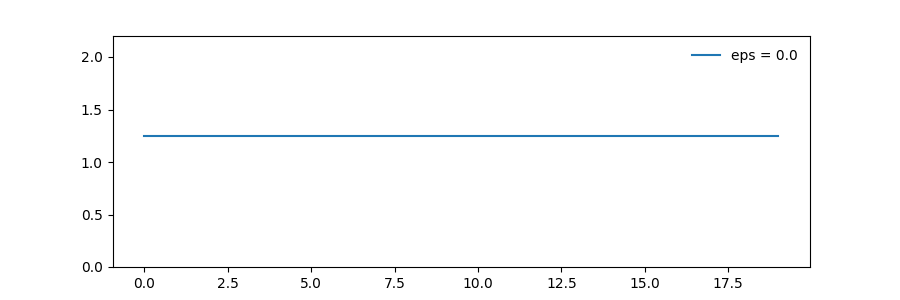

In [160]:
Nexp = 1 # 2000
Npulls = 20 # 3000 
avg_outcome_eps0p0 = np.zeros(Npulls) 
avg_outcome_eps0p01 = np.zeros(Npulls) 
avg_outcome_eps0p1 = np.zeros(Npulls) 

for i in range(Nexp): 
   bandit = Bandit() 
   avg_outcome_eps0p0 += experiment(bandit,Npulls,0.0) 
   #bandit = Bandit() 
   #avg_outcome_eps0p01 += experiment(bandit,Npulls,0.01) 
   #bandit = Bandit() 
   #avg_outcome_eps0p1 += experiment(bandit,Npulls,0.1) 

print(avg_outcome_eps0p0)
    
avg_outcome_eps0p0 /= np.float(Nexp) 
#avg_outcome_eps0p01 /= np.float(Nexp) 
#avg_outcome_eps0p1 /= np.float(Nexp) 

plt.plot(avg_outcome_eps0p0,label="eps = 0.0") 
#plt.plot(avg_outcome_eps0p01,label="eps = 0.01") 
#plt.plot(avg_outcome_eps0p1,label="eps = 0.1") 
plt.ylim(0,2.2) 
plt.legend() 
plt.show()



## UCB1

<img  src="LTSDJ96BDFOU5XODPN6DJ9R7GGYA0OFB.png"/>

More info at https://jeremykun.com/2013/10/28/optimism-in-the-face-of-uncertainty-the-ucb1-algorithm/

## MCTS

<img  src="MCTS_(English).svg.png"/>

# Example: Bayes bandit

Beta distribution is defined as 

$Beta(x|\alpha, \beta) = \dfrac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}x^{\alpha-1}(1 - x)^{\beta-1}. $

Basically a probability distribution describing probability of probabilities, in this case CTR.

The mean is

$E[x] = \dfrac{\alpha}{\alpha + \beta}.$

A/B testing is only exploration, less statistical significance, but higher average reward

A/B is special case of MAB

## Sample plots

<IPython.core.display.Javascript object>


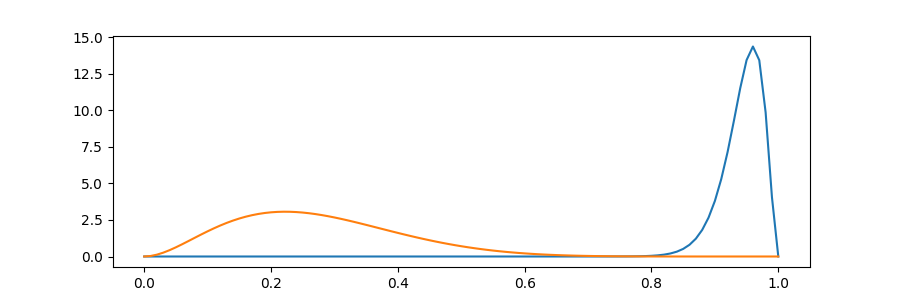

In [13]:
# from scipy.special import gamma
from scipy.stats import beta

def pdf(a, b, x):
    rv = beta(a, b)
    return rv.pdf(x)

def beta_plot(a, b):
    x = np.arange(0.0, 1.01, 0.01)
    y = pdf(a, b, x)
    plt.plot(x, y)

plt.figure(1)
#beta_plot(1, 1)
#beta_plot(2, 2)
#beta_plot(3, 3)
#beta_plot(1, 6)
beta_plot(50, 3)
beta_plot(3, 8)
plt.show()

## Code for banners/bandits

In [15]:
from scipy.stats import beta
from random import random
 
class Banner():
    def __init__(self, CTR, alpha=1, beta=1):
        self.CTR = CTR
        self.alpha = alpha
        self.beta = beta
 
    def update(self, click):
        if click == True:
            self.alpha += 1
        else:
            self.beta += 1
 
    def sample(self):
        return beta(self.alpha, self.beta).rvs()
 
    def getCTR(self):
        return self.CTR
 
class BayesBandit:
    def __init__(self, CTRs):
        self.banners = []
        for CTR in CTRs:
            self.banners.append(Banner(CTR))
 
    def selectBanner(self):
        sampledCTRs = [banner.sample() for banner in self.banners]
        return sampledCTRs.index(max(sampledCTRs))
 
    def simulateUser(self, banner):
        CTR = self.banners[banner].getCTR()
        if random() > CTR:
            self.banners[banner].update(False)
        else:
            self.banners[banner].update(True)        

## Simulation

In [17]:
bandit = BayesBandit([0.25, 0.4, 0.67])
for i in range(100):
    banner = bandit.selectBanner()
    bandit.simulateUser(banner)
    print("User clicked on banner %d" % (banner + 1))

User clicked on banner 2
User clicked on banner 3
User clicked on banner 1
User clicked on banner 2
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 2
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 2
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 3
User clicked on banner 2
User clicked on banner 3


<IPython.core.display.Javascript object>


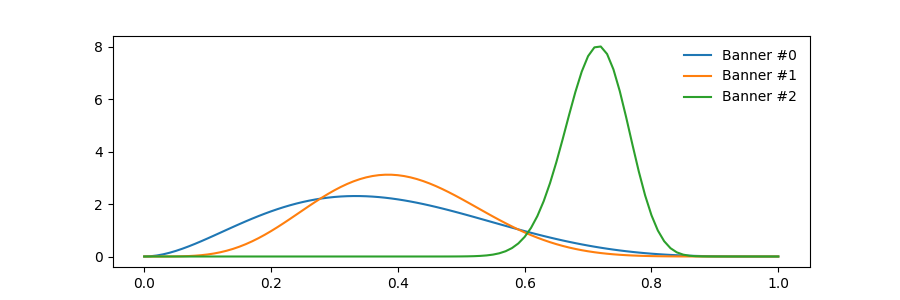

Banner #0, a=  3, b=  5, real_CTR=0.250, mean=0.375
Banner #1, a=  6, b=  9, real_CTR=0.400, mean=0.400
Banner #2, a= 59, b= 24, real_CTR=0.670, mean=0.711


In [18]:
plt.figure(2)

num_banners = len(bandit.banners)
for i in range(num_banners):
    a = bandit.banners[i].alpha
    b = bandit.banners[i].beta
    print("Banner #%d, a=%3d, b=%3d, real_CTR=%1.3f, mean=%1.3f" % \
          (i, a,b, bandit.banners[i].CTR, a/(a+b)))
    beta_plot(a, b)

plt.legend(["Banner #%d" % i for i in range(num_banners)])
plt.show() 


# Relation to RL

In [19]:
YouTubeVideo("ZtP4eEYjJ2I", start=timedelta(seconds=24))

In [20]:
YouTubeVideo("V1eYniJ0Rnk", start=timedelta(seconds=25))